## Analysis of GATA3 mutations

This notebook is meant to analyze the effect of GATA3 truncating mutations in breast cancer.

In [2]:
# import needed packages
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
from matplotlib_venn import venn2, venn2_circles
mpl.rcParams['pdf.fonttype'] = 42
import utils
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Read in necessary BRCA subtype information

In [3]:
subtype_df = pd.read_table('data/misc/tcga_pathway_group_subtypes.txt')

# process subtype data
rename_dict = {'PATIENT_BARCODE': 'PatientID', 'DISEASE': 'CODE', 'SUBTYPE': 'subtype'}
subtype_df = subtype_df.rename(columns=rename_dict)

### GATA3 Null Distribution

Here, we show that the observed loss of degron potential is substantial greater than expected based on a simulated null distribution where mutations would randomly accumulate in tumor samples.

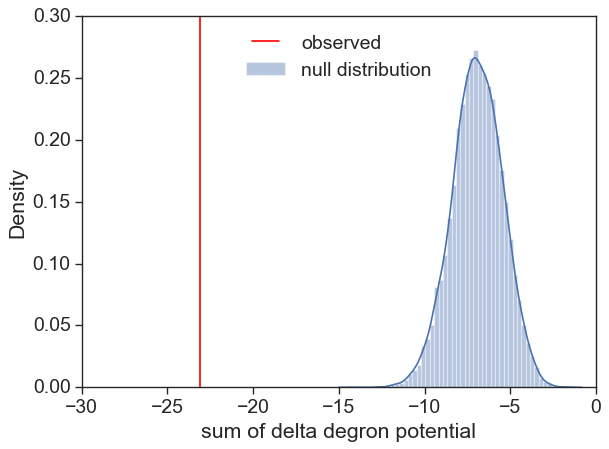

In [4]:
# read in null distribution
df = pd.read_table('data/gata3/gata3_null.txt')

# plot the distribution for GATA3
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.6):
    sns.distplot(df['simulated delta degron potential'], label='null distribution')
    plt.axvline(-23.1, color='red', label='observed')
    plt.xlim(-30, 0)
    plt.xlabel('sum of delta degron potential')
    plt.ylabel('Density')
    plt.legend(loc='best',frameon=False)
    plt.tight_layout()
    plt.savefig('figures/gata3_null_distribution.pdf')

### Analysis of the putative degron of GATA3

In [7]:
gata3_df = pd.read_table('data/gata3/GATA3.txt')
gata3_df['alt'] = gata3_df['Substitution'].str[-1:]
gata3_df['ref'] = gata3_df['Substitution'].str[:1]
gata3_df['pos'] = gata3_df['Substitution'].str[1:-1].astype(int)
baseline = gata3_df[gata3_df['ref']==gata3_df['alt']]['degron potential'].iloc[0]
#heatmap = pd.pivot_table(index='alt', columns='pos', values='degron potential', data=gata3_df)


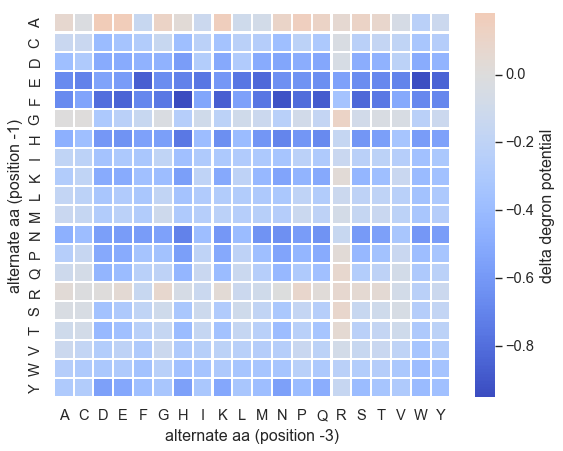

In [8]:
with sns.plotting_context('notebook', font_scale=1.2):
    gata3_dimotif = pd.read_csv('data/gata3/GATA3_dimotif.txt', sep='\t')
    gata3_dimotif = gata3_dimotif.rename(columns={'aa -1': 'alternate aa (position -1)', 'aa -3': 'alternate aa (position -3)'})
    heatmap = pd.pivot_table(index='alternate aa (position -1)', columns='alternate aa (position -3)', 
                             values='degron potential', data=gata3_dimotif)
    sns.heatmap(heatmap-baseline,
                cbar_kws={'label': 'delta degron potential'},
                cmap='coolwarm', linewidth=1,
                center=0)
    plt.savefig('figures/gata3_dimotif_heatmap.pdf')

### Correlate with target gene expression

In [9]:
# read in gata3 targets
gata3_reg_potential = pd.read_table('data/gata3/gata3_T47D_44397_gene_score_5fold.txt', skiprows=5)
gata3_reg_potential = gata3_reg_potential.drop_duplicates(subset=['symbol'])
gata3_reg_potential = gata3_reg_potential[gata3_reg_potential['refseq'].str.startswith('NM_')]

# get top 100
top100 = gata3_reg_potential.symbol.iloc[:100].tolist()

The next step is to read in the breast cancer gene expression and somatic mutations from TCGA.

In [10]:
# expression data
expr_df = pd.read_table('data/gata3/tcga_brca_gene_expr_rsem_v2.txt').set_index('gene_id')
expr_df = np.log2(expr_df+1)
quant_df = expr_df.rank(axis=1, pct=True)

# get gata3 expression
gata3_expr = expr_df.loc['GATA3']
gata3_quantile = quant_df.loc['GATA3']

# read in mutations
mut_df = pd.read_table('data/misc/mc3.v0.2.8.PUBLIC.code.filtered.small.maf')
mut_df = mut_df[mut_df['CODE']=='BRCA'].copy()
mut_df['patient_id'] = mut_df['Tumor_Sample_Barcode'].str[:12]

We will only be focusing on GATA3 frameshift, nonsense and splice site mutations.

In [24]:
# label different type of GATA3 mutations
import re
nonsil = [
    'Frame_Shift_Del', 'Frame_Shift_Ins', 
    'Nonsense_Mutation', 
    'Splice_Site'
]
is_gata3 = mut_df['Hugo_Symbol']=='GATA3'
gata3_pos = mut_df['HGVSp_Short'].apply(lambda x: int(re.findall('[0-9]+', x)[0]) if re.search('[0-9]+', x) else -1)
mut_df['GATA3_mut'] = 0
is_fs = mut_df['Variant_Classification'].isin(nonsil)
mut_df.loc[is_gata3 & is_fs & (gata3_pos<=341), 'GATA3_mut'] = 2
mut_df.loc[is_gata3 & is_fs & (gata3_pos>341), 'GATA3_mut'] = 1

# analyze the mutation status
gata3_mut = mut_df.groupby('patient_id')['GATA3_mut'].max()
mut_status = pd.DataFrame({'GATA3': gata3_mut})
mut_status['GATA3'] = mut_status['GATA3'].fillna(0).astype(int)

# find the list of samples with double mutations vs no mutation at all
num_gene_muts = mut_status.sum(axis=1)

Now, we plot the relationship between GATA3 mutation and its relation to target gene expression.

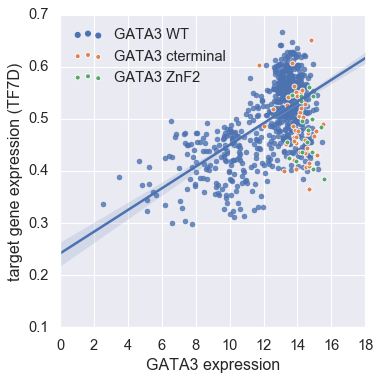

In [25]:
with sns.plotting_context('notebook', font_scale=1.2):
    mean_quantile = quant_df.loc[top100].mean()
    tmp_df = pd.DataFrame({'GATA3 quant': gata3_quantile, 
                           'GATA3 expr': gata3_expr,
                           "Mean target": mean_quantile, 
                           'GATA3 mut': mut_status['GATA3']})
    tmp_df = pd.merge(tmp_df, subtype_df[['PatientID', 'subtype']], 
                      left_index=True, right_on='PatientID', how='left').dropna()
    sns.lmplot('GATA3 expr', 'Mean target', 
               data=tmp_df[tmp_df['GATA3 mut']==0],
               scatter_kws={'label':'GATA3 wt'})
    plt.scatter([], [],  color=sns.color_palette()[0],
                label='GATA3 WT')
    sns.scatterplot('GATA3 expr', 'Mean target', data=tmp_df[tmp_df['GATA3 mut']==1], 
                    color=sns.color_palette()[1],
                    label='GATA3 cterminal',)
    sns.scatterplot('GATA3 expr', 'Mean target', data=tmp_df[tmp_df['GATA3 mut']==2], 
                    color=sns.color_palette()[2],
                    label='GATA3 ZnF2',)
    plt.xlabel('GATA3 expression')
    plt.ylabel('target gene expression (TF7D)')
    plt.legend(loc='best', frameon=False)
    plt.xlim(0, 18)
    plt.tight_layout()
    plt.savefig('figures/gata3_target_gene_expression.pdf')

From visual examination of the above plot, it seemed like there was a tendency for GATA3 mutant tumor samples to below the regression for target gene expression level. We therefore tested for it statistically through the betareg R package.

In [26]:
tmp_df2 = tmp_df.copy()
tmp_df2['GATA3 mut'] = "Variant_"+tmp_df['GATA3 mut'].astype(str) #[tmp_df['GATA3 mut']!=1]

In [27]:
%%R -i tmp_df2 -o pred
library(betareg)
gata3Model <- lm(Mean.target ~ GATA3.expr + subtype + GATA3.mut, data=tmp_df2)
pred <- predict(gata3Model, tmp_df2)
summary(gata3Model)


Call:
lm(formula = Mean.target ~ GATA3.expr + subtype + GATA3.mut, 
    data = tmp_df2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.142093 -0.033203  0.004017  0.035914  0.148172 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.376887   0.015240  24.731  < 2e-16 ***
GATA3.expr            0.003090   0.001587   1.947 0.051918 .  
subtypeHer2           0.062650   0.008809   7.112 2.68e-12 ***
subtypeLumA           0.122027   0.008528  14.309  < 2e-16 ***
subtypeLumB           0.083247   0.009161   9.087  < 2e-16 ***
subtypeNormal         0.088794   0.010355   8.575  < 2e-16 ***
GATA3.mutVariant_1.0 -0.041841   0.008072  -5.183 2.80e-07 ***
GATA3.mutVariant_2.0 -0.045189   0.012442  -3.632 0.000301 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0498 on 749 degrees of freedom
Multiple R-squared:  0.509,	Adjusted R-squared:  0.5044 
F-statistic: 110.9 on 7 and 749 

### save file of gata3 mutant samples

Here, we save the labeling of GATA3 mutant tumor samples.

In [45]:
# prepare data
luma_lumb = subtype_df.loc[subtype_df['subtype'].isin(['LumA', 'LumB']), 'PatientID']
tmp = fs_df[fs_df['PatientID'].isin(luma_lumb)].rename(columns={'GATA3 mutation': 'GATA3'}).copy()
tmp1 = tmp[tmp['GATA3']!='GATA3 ZnF2'].copy()
tmp2 = tmp[tmp['GATA3']!='GATA3 cterminal'].copy()

# save c-terminal comparison
replace_vals = {'GATA3 cterminal': 1, 'GATA3 WT': 0}
tmp1['GATA3'] = tmp1['GATA3'].apply(replace_vals.get)
tmp1.to_csv('results/BRCA_gata3_cterminal.txt', sep='\t', index=False)

# save ZnF2 comparison
replace_vals = {'GATA3 ZnF2': 1, 'GATA3 WT': 0}
tmp2['GATA3'] = tmp2['GATA3'].apply(replace_vals.get)
tmp2.to_csv('results/BRCA_gata3_znf2.txt', sep='\t', index=False)

### GATA3 protein expression

Given the above evidence, we reasoned that we should also see an effect on GATA3 protein-levels. We therefore examined protein expression from Reverse Phase Protein Arrays (RPPA) for tumors with GATA3 frameshift vs not.

In [28]:
# read in data
rppa_df = pd.read_table('data/rppa/TCGA-RPPA-pancan-clean.txt')

# process data:

# mutation data
mut_df['PatientID'] = mut_df['Tumor_Sample_Barcode'].str[:12]
# protein data
rppa_df['PatientID'] = rppa_df['SampleID'].str[:12]
brca_df = rppa_df[rppa_df['TumorType']=='BRCA'].copy()

# merge dataframe
rename_dict = {0: 'GATA3 WT', 1: 'GATA3 cterminal', 2: 'GATA3 ZnF2'}
mut_df['GATA3 mutation'] = mut_df['GATA3_mut'].apply(rename_dict.get)
#fs_df = mut_df.groupby('PatientID')['GATA3 Frameshift'].max().reset_index()
fs_df = mut_df.groupby('PatientID')['GATA3 mutation'].max().reset_index()
merged_df = pd.merge(brca_df, fs_df, on='PatientID', how='left')
merge_cols = ['PatientID', 'subtype']
merged_df = pd.merge(merged_df, subtype_df[merge_cols], on='PatientID', how='left')
# merge expression
gata3_expr_df = expr_df.T[['GATA3']].reset_index().rename(columns={'index': 'PatientID', 'GATA3': 'GATA3 expression'})
merged_df = pd.merge(merged_df, gata3_expr_df[['PatientID', 'GATA3 expression']], on='PatientID', how='left')

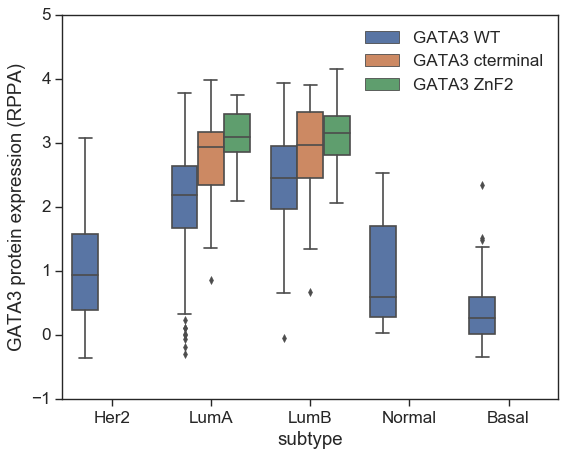

In [19]:
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.4):
    sns.boxplot('subtype', 'GATA3', hue='GATA3 mutation', data=merged_df)
    plt.ylabel('GATA3 protein expression (RPPA)')
    plt.legend(frameon=False)
    plt.savefig('figures/gata3_rppa.pdf')

While there appears to be a difference in protein expression from the above plot, we next wanted to statistically test whether GATA3 protein expression is elevated in GATA3 frameshift tumors.

In [29]:
# prepare the dataframe to be passed into R
mycols = ['GATA3', 'GATA3 expression', 'GATA3 mutation', 'subtype']
rename_dict = {'GATA3 expression': 'expression', 'GATA3 mutation': 'mutation'}
r_df = merged_df[mycols].rename(columns=rename_dict).dropna().copy()
r_df.loc[r_df['mutation'].isin(['GATA3 ZnF2', 'GATA3 cterminal']), 'mutation'] = 'yes'
r_df.loc[r_df['mutation']=='GATA3 WT', 'mutation'] = 'no'

In [30]:
%%R -i r_df
summary(lm(GATA3 ~ expression + subtype + mutation, data=r_df))


Call:
lm(formula = GATA3 ~ expression + subtype + mutation, data = r_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.49169 -0.32247  0.02364  0.40022  1.51278 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -2.64358    0.21185 -12.479  < 2e-16 ***
expression     0.32475    0.02186  14.857  < 2e-16 ***
subtypeHer2   -0.01627    0.11904  -0.137 0.891329    
subtypeLumA    0.40925    0.11818   3.463 0.000570 ***
subtypeLumB    0.67112    0.12628   5.314 1.49e-07 ***
subtypeNormal -0.12004    0.15243  -0.788 0.431256    
mutationyes    0.40402    0.10360   3.900 0.000107 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6562 on 632 degrees of freedom
Multiple R-squared:  0.6569,	Adjusted R-squared:  0.6536 
F-statistic: 201.7 on 6 and 632 DF,  p-value: < 2.2e-16



Indeed, we do see that GATA3 frameshifts are associated with higher GATA3 protein expression, as evidenced by the significant positive coefficient in the linear regression model.

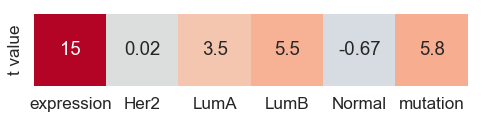

In [117]:
tvalues = pd.DataFrame({'t value': [14.599, 0.02, 3.539, 5.475, -0.667, 5.831]}, 
                       index=['expression', 'Her2', 'LumA', 'LumB', 'Normal', 'mutation'])
with sns.plotting_context('notebook', font_scale=1.4):
    g = sns.heatmap(tvalues.T, cmap='coolwarm', center=0, square=True, cbar=False, annot=True)
    plt.gcf().set_size_inches(7, 2)
    plt.savefig('figures/gata3_t_value_heatmap.pdf')

### Supplementary tables

Here, we prepare the GSEA tables for GATA3 mutant vs wildtype comparison.

In [183]:
gsea_znf2 = pd.read_csv('data/gata3/gata3_gsea_znf2.txt', sep='\t')
gsea_cterminal = pd.read_csv('data/gata3/gata3_gsea_cterminal.txt', sep='\t')

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('tables/TableS8.xlsx', engine='xlsxwriter')

# save sheets
out_cols = ['Description', 'setSize', 'enrichmentScore', 'NES', 'pvalue', 'p.adjust']
gsea_znf2[out_cols].to_excel(writer, sheet_name='GATA3 ZnF2 GSEA', float_format='%.2G', index=False)
gsea_cterminal[out_cols].to_excel(writer, sheet_name='GATA3 c-terminal GSEA', float_format='%.2G', index=False)

# finish savining
writer.save()